# Voting and Polling History

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Historical-plots" data-toc-modified-id="Historical-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Historical plots</a></span><ul class="toc-item"><li><span><a href="#Minor-parties" data-toc-modified-id="Minor-parties-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Minor parties</a></span></li><li><span><a href="#Mainstream-parties" data-toc-modified-id="Mainstream-parties-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Mainstream parties</a></span></li><li><span><a href="#Election-cycles" data-toc-modified-id="Election-cycles-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Election cycles</a></span></li></ul></li><li><span><a href="#Polling-history" data-toc-modified-id="Polling-history-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Polling history</a></span><ul class="toc-item"><li><span><a href="#Overview-of-past-elections" data-toc-modified-id="Overview-of-past-elections-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Overview of past elections</a></span></li><li><span><a href="#Individual-elections" data-toc-modified-id="Individual-elections-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Individual elections</a></span></li></ul></li><li><span><a href="#Simple-Bayesian-analysis-of-2pp-polling-errors-since-1983-(inc.)" data-toc-modified-id="Simple-Bayesian-analysis-of-2pp-polling-errors-since-1983-(inc.)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simple Bayesian analysis of 2pp polling errors since 1983 (inc.)</a></span><ul class="toc-item"><li><span><a href="#Get-the-data-we-want-to-look-at" data-toc-modified-id="Get-the-data-we-want-to-look-at-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Get the data we want to look at</a></span></li><li><span><a href="#Quick-look-at-the-distribution-of-errors" data-toc-modified-id="Quick-look-at-the-distribution-of-errors-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Quick look at the distribution of errors</a></span></li><li><span><a href="#Build-and-run-a-Bayesian-model-using-Student's-t-distribution" data-toc-modified-id="Build-and-run-a-Bayesian-model-using-Student's-t-distribution-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Build and run a Bayesian model using Student's t-distribution</a></span></li><li><span><a href="#Extract-hyper_nu" data-toc-modified-id="Extract-hyper_nu-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Extract hyper_nu</a></span></li><li><span><a href="#Let's-look-at-our-proposed-Student-t-distribution" data-toc-modified-id="Let's-look-at-our-proposed-Student-t-distribution-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Let's look at our proposed Student-t distribution</a></span></li></ul></li><li><span><a href="#Bayesian-estimation-of-other-party-polling-errors-since-1983" data-toc-modified-id="Bayesian-estimation-of-other-party-polling-errors-since-1983-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Bayesian estimation of other party polling errors since 1983</a></span><ul class="toc-item"><li><span><a href="#Get-and-adjust-primary-polling-data" data-toc-modified-id="Get-and-adjust-primary-polling-data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Get and adjust primary polling data</a></span></li><li><span><a href="#Summary-plot-of-other-primary-votes" data-toc-modified-id="Summary-plot-of-other-primary-votes-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Summary plot of other primary votes</a></span></li><li><span><a href="#Bayesian-estimate" data-toc-modified-id="Bayesian-estimate-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Bayesian estimate</a></span></li></ul></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Watermark</a></span></li></ul></div>

## Python setup

In [1]:
# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.api as sm
import scipy.stats as ss

# Bayesian modelling ...
import pymc as pm
import arviz as az

# system imports
from io import StringIO
import pathlib

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR

In [2]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

## Data

In [3]:
data = """
Year    Date         ALP     LP      LNP  NP      CLP  DLP  DEM     GRN     ON   Others GovtBefore GovtAfter Labor2pp
1946    28-Sep-1946  49.7    33.0    -    10.7    -    -    -       -       -    6.6    Labor      Labor     54.1
1949    10-Dec-1949  46.0    39.3    -    10.8    -    -    -       -       -    3.9    Labor      Coalition 49.0
1951    28-Apr-1951  47.7    40.5    -    9.7     -    -    -       -       -    2.1    Coalition  Coalition 49.3
1954    29-May-1954  50.1    38.5    -    8.5     -    -    -       -       -    2.9    Coalition  Coalition 50.7
1955    10-Dec-1955  44.7    39.7    -    7.9     -    5.1  -       -       -    2.6    Coalition  Coalition 45.8
1958    22-Nov-1958  42.9    37.1    -    9.3     -    9.4  -       -       -    1.3    Coalition  Coalition 45.9
1961    09-Dec-1961  48.0    33.5    -    8.5     -    8.7  -       -       -    1.4    Coalition  Coalition 50.5
1963    30-Nov-1963  45.5    37.1    -    8.9     -    7.4  -       -       -    1.0    Coalition  Coalition 47.4
1966    26-Nov-1966  40.0    40.1    -    9.8     -    7.3  -       -       -    2.7    Coalition  Coalition 43.1
1969    25-Oct-1969  47.0    34.8    -    8.6     -    6.0  -       -       -    3.7    Coalition  Coalition 50.2
1972    02-Dec-1972  49.6    32.0    -    9.4     -    5.2  -       -       -    3.7    Coalition  Labor     52.7
1974    18-May-1974  49.3    34.9    -    10.8    -    1.4  -       -       -    3.5    Labor      Labor     51.7
1975    13-Dec-1975  42.8    41.8    -    11.0    0.2  1.3  -       -       -    2.8    Labor      Coalition 44.3
1977    10-Dec-1977  39.6    38.1    -    9.8     0.2  1.4  9.4     -       -    1.4    Coalition  Coalition 45.4
1980    18-Oct-1980  45.1    37.4    -    8.6     0.2  0.3  6.6     -       -    1.7    Coalition  Coalition 49.6
1983    05-Mar-1983  49.5    34.4    -    9.0     0.2  0.2  5.0     -       -    1.7    Coalition  Labor     53.2
1984    01-Dec-1984  47.5    34.1    -    10.6    0.3  0.6  5.4     -       -    1.4    Labor      Labor     51.8
1987    11-Jul-1987  45.8    34.3    -    11.5    0.2  -    6.0     -       -    2.0    Labor      Labor     50.8
1990    24-Mar-1990  39.4    34.8    -    8.4     0.3  -    11.3    1.4     -    4.4    Labor      Labor     49.9
1993    13-Mar-1993  44.9    36.8    -    7.2     0.3  -    3.8     1.9     -    5.2    Labor      Labor     51.4
1996    02-Mar-1996  38.8    38.7    -    8.2     0.4  -    6.8     2.9     -    4.3    Labor      Coalition 46.4
1998    03-Oct-1998  40.1    33.9    -    5.3     0.3  -    5.1     2.6     8.4  4.2    Coalition  Coalition 51.0
2001    10-Nov-2001  37.8    37.1    -    5.6     0.3  -    5.4     5.0     4.3  4.4    Coalition  Coalition 49.0
2004    09-Oct-2004  37.6    40.5    -    5.9     0.3  -    1.2     7.2     1.2  6.0    Coalition  Coalition 47.3
2007    24-Nov-2007  43.4    36.3    -    5.5     0.3  -    0.7     7.8     0.3  5.8    Coalition  Labor     52.7
2010    21-Aug-2010  38.0    30.5    9.1  3.7     0.3  -    0.2     11.8    0.2  6.2    Labor      Labor     50.1
2013    07-Sep-2013  33.4    32.0    8.9  4.3     0.3  0.3  -       8.6     0.2  11.9   Labor      Coalition 46.5
2016    02-Jul-2016  34.7    28.7    8.5  4.6     0.2  -    -       10.2    1.3  11.7   Coalition  Coalition 49.6
2019    18-May-2019  33.34   27.99   8.67 4.51    0.27 -    -       10.40   3.08 11.74  Coalition  Coalition 48.5
"""
# https://en.wikipedia.org/wiki/Two-party-preferred_vote
# https://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Library/pubs/rp/rp1617/FederalElectionResults


In [4]:
table = pd.read_csv(StringIO(data), header=0, index_col=0, 
                    skipinitialspace=True, sep=' ', na_values='-',
                    parse_dates=['Date'])
table

,Date,ALP,LP,LNP,NP,CLP,DLP,DEM,GRN,ON,Others,GovtBefore,GovtAfter,Labor2pp
Year,,,,,,,,,,,,,,
1946,1946-09-28,49.70,33.00,NaN,10.70,NaN,NaN,NaN,NaN,NaN,6.60,Labor,Labor,54.1
1949,1949-12-10,46.00,39.30,NaN,10.80,NaN,NaN,NaN,NaN,NaN,3.90,Labor,Coalition,49.0
1951,1951-04-28,47.70,40.50,NaN,9.70,NaN,NaN,NaN,NaN,NaN,2.10,Coalition,Coalition,49.3
1954,1954-05-29,50.10,38.50,NaN,8.50,NaN,NaN,NaN,NaN,NaN,2.90,Coalition,Coalition,50.7
1955,1955-12-10,44.70,39.70,NaN,7.90,NaN,5.1,NaN,NaN,NaN,2.60,Coalition,Coalition,45.8
1958,1958-11-22,42.90,37.10,NaN,9.30,NaN,9.4,NaN,NaN,NaN,1.30,Coalition,Coalition,45.9
1961,1961-12-09,48.00,33.50,NaN,8.50,NaN,8.7,NaN,NaN,NaN,1.40,Coalition,Coalition,50.5
1963,1963-11-30,45.50,37.10,NaN,8.90,NaN,7.4,NaN,NaN,NaN,1.00,Coalition,Coalition,47.4
1966,1966-11-26,40.00,40.10,NaN,9.80,NaN,7.3,NaN,NaN,NaN,2.70,Coalition,Coalition,43.1


In [5]:
coalition = ['LP', 'LNP', 'NP', 'CLP']
e_others = ['DLP', 'DEM', 'GRN', 'ON', 'Others']
primary = ['ALP', 'LP', 'LNP', 'NP', 'CLP', 'DLP', 'DEM', 'GRN', 'ON', 'Others']

In [6]:
# quick data consistency checks
assert(table.index.is_monotonic_increasing)
row_sums = table[primary].sum(axis=1, skipna=True)
assert((row_sums >= 99.8).all() and (row_sums <= 100.2).all())
assert((table['ALP'] < table['Labor2pp']).all())
assert(len(table['GovtBefore'].unique()) == 2)
assert(len(table['GovtAfter'].unique()) == 2)
assert((table['Date'].dt.year == table.index).all())

## Historical plots

### Minor parties

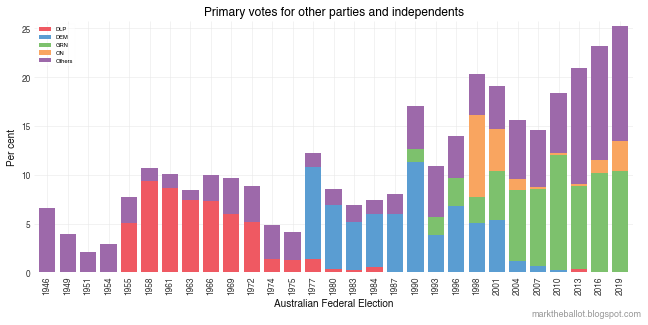

In [7]:
fig, ax = common.initiate_plot()
table[e_others].plot.bar(stacked=True, ax=ax, width=0.8)
common.plot_finalise(ax, title='Primary votes for other parties and independents', 
              xlabel="Australian Federal Election", ylabel='Per cent', lfooter=None)

### Mainstream parties

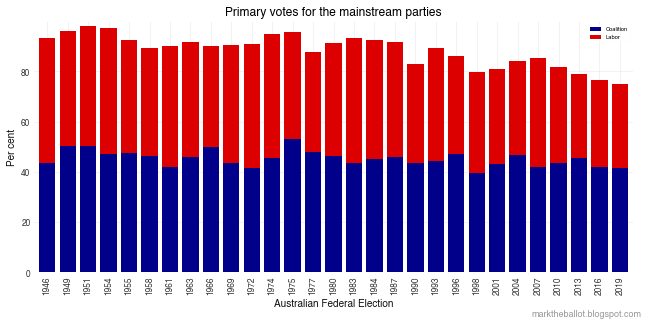

In [8]:
mainstream = table.copy()
mainstream['Coalition'] = mainstream[coalition].sum(axis=1)
mainstream = mainstream.rename(columns={'ALP': 'Labor'})
majors = ['Coalition', 'Labor']
fig, ax = common.initiate_plot()
mainstream[majors].plot.bar(stacked=True, ax=ax, width=0.8, 
                       color=[COLOR_COALITION, COLOR_LABOR])
common.plot_finalise(ax, title='Primary votes for the mainstream parties', 
              xlabel="Australian Federal Election", ylabel='Per cent', lfooter=None)

### Election cycles

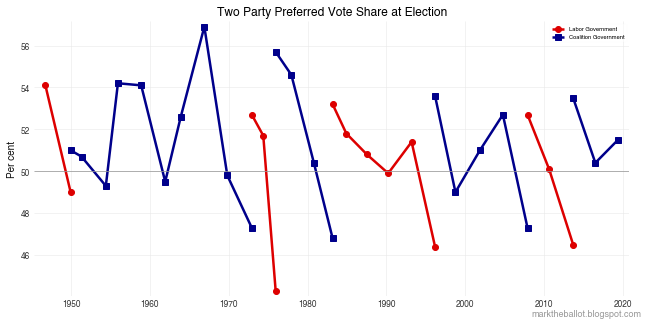

In [9]:
# identify changes of government at an election ...
changes = table['GovtBefore'] != table['GovtAfter']
change_points = changes[changes].index.values
final = table.index[-1]
if final not in change_points:
    change_points = np.append(change_points, table.index[-1])

# construct separate runs for each multi-term government
MARKER_LABOR, MARKER_COALITION = 'o', 's'
cycles = pd.DataFrame(index=table.Date)
colors = {}
markers = {}
start = table.index[0]
for i, ending in enumerate(change_points):
    name = f'{start}-{ending}'
    selection = table.index[(table.index >= start) 
                            & (table.index <= ending)]
    dates = table.loc[selection].Date
    values = table.loc[selection].Labor2pp
    if table.loc[start, 'GovtAfter'] == "Coalition":
        values = 100 - values
        colors[name] = COLOR_COALITION
        markers[name] = MARKER_COALITION
    else:
        colors[name] = COLOR_LABOR
        markers[name] = MARKER_LABOR
    values.index = dates
    cycles[name] = values
    start = ending

# plot
LW = 2.5
fig, ax = common.initiate_plot()
for column in cycles.columns:
    cycles[column].plot.line(ax=ax, marker=markers[column], 
                             c=colors[column], linewidth=LW)

# reference line
ax.axhline(y=50, color='#999999', linestyle='-', linewidth=0.75)

# custom legend
custom_lines = [
    Line2D([0], [0], color=COLOR_LABOR, lw=LW, marker=MARKER_LABOR),
    Line2D([0], [0], color=COLOR_COALITION, lw=LW, marker=MARKER_COALITION)
]
ax.legend(custom_lines, ['Labor Government', 'Coalition Government'])

# finalise plot
common.plot_finalise(ax, xlabel=None, ylabel='Per cent', lfooter=None,
                     title='Two Party Preferred Vote Share at Election',
                     concise_dates=True, straighten_tl=True)

## Polling history

In [10]:
# Historical polling data from Ethan at https://armariuminterreta.com/
historical = pd.read_excel('../historical-data/Australian Federal Polling Database.xlsx',)
len(historical)

3252

In [11]:
# quick peak at the polling data (if needed)
if False:
    display(historical.head())
    print(historical.dtypes)

In [12]:
# Get election data
# We will focus on polls in the last N Weeks of the campaign
elections = table[['Date', 'Labor2pp']].copy()
elections['Coalition2pp'] = 100.0 - elections['Labor2pp']
len(elections)

29

In [13]:
# some useful constants
COALITION_TPP = 'Est2pp'
ELECTION_MARKER = 's'
POLL_MARKER = 'o'
ELECTION_COLOR = 'darkorange'
data_statement = (
    'Data from Ethan at https://armariuminterreta.com/ '
    '(with input from William Bowe and Kevin Bonham); '
    '2pp from primary votes.'
)
SUMMARY_FOCUS = 5 # WEEKS
SUMMARY_START = pd.Timestamp('1972-01-01')


### Overview of past elections

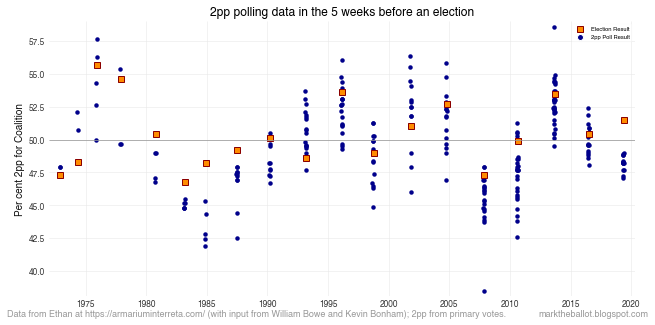

In [14]:
# plot the poll data prior to an election
fig, ax = common.initiate_plot()
for election_day in elections.Date:

    # ignore early polls
    if election_day < SUMMARY_START:
        continue
    
    # get polling data
    focus_days = SUMMARY_FOCUS * 7 # days
    election_2pp = elections.at[election_day.year, 'Coalition2pp']
    start = election_day - pd.Timedelta(days=focus_days)
    selected = historical[(historical.StartDate >= start)
                          & (historical.EndDate <= election_day)].copy()

    # --- add to the summary plot
    # polling
    selected.plot(kind='scatter', x='EndDate', y=COALITION_TPP, ax=ax, 
                  c=COLOR_COALITION, marker=POLL_MARKER)
    
    # election
    ax.plot([election_day], [election_2pp],
            c=ELECTION_COLOR, markeredgecolor='darkred', marker=ELECTION_MARKER)
    

# legend
legend_body = [Line2D([0], [0], marker=ELECTION_MARKER, color='w', label='Election Result',
                          markerfacecolor=ELECTION_COLOR, markeredgecolor='darkred', ),
              Line2D([0], [0], marker=POLL_MARKER, color='w', label='2pp Poll Result',
                          markerfacecolor=COLOR_COALITION)]
ax.legend(handles=legend_body, loc='best')

# reference line
ax.axhline(y=50, color='#999999', linestyle='-', linewidth=0.75)

# finalise
common.plot_finalise(ax, xlabel=None, ylabel='Per cent 2pp for Coalition', 
                     lfooter= data_statement,
                     title=f'2pp polling data in the {SUMMARY_FOCUS} '
                           'weeks before an election',
                     concise_dates=True, straighten_tl=True)

### Individual elections

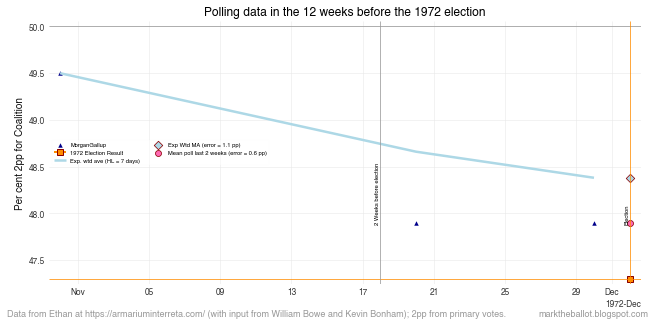

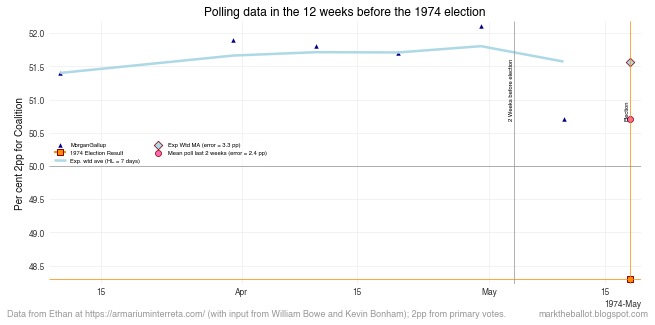

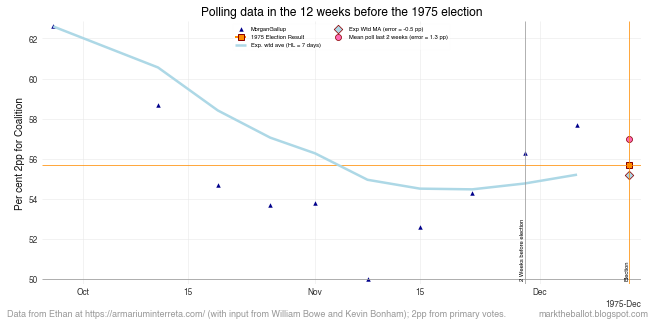

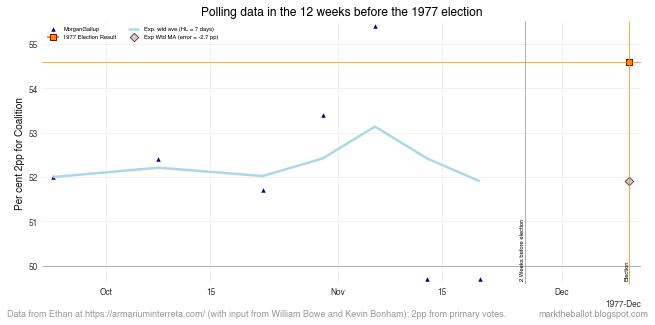

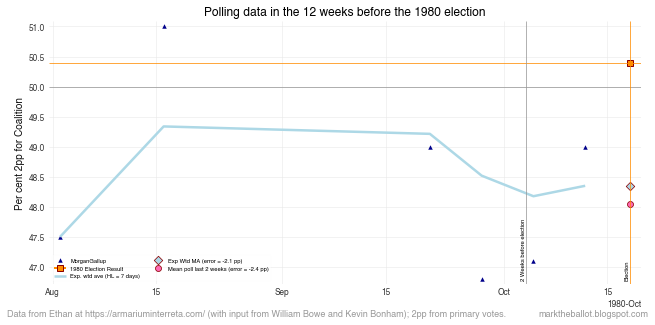

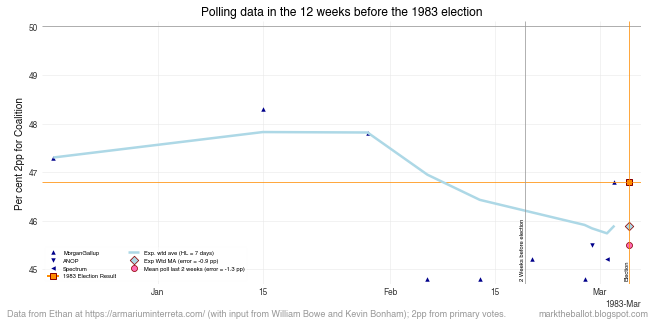

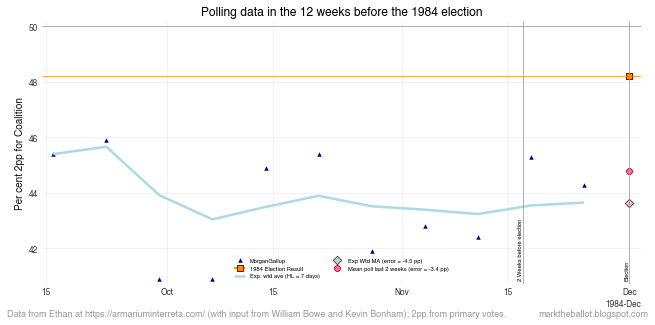

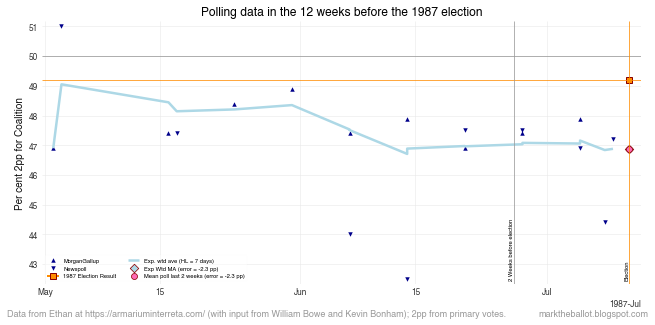

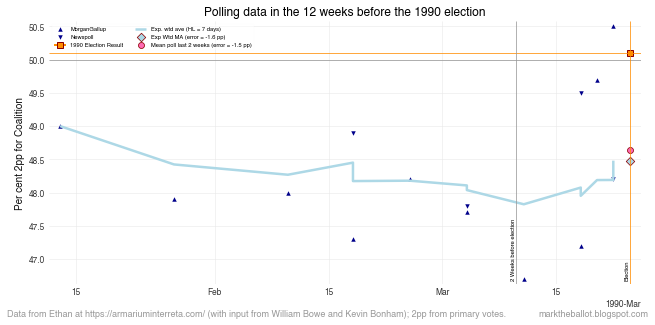

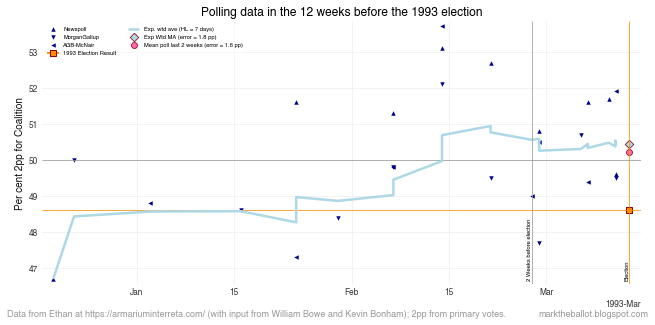

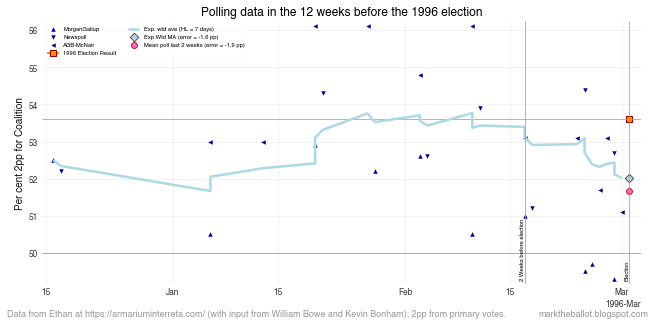

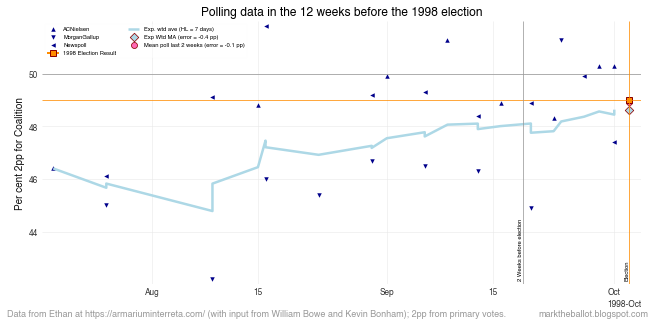

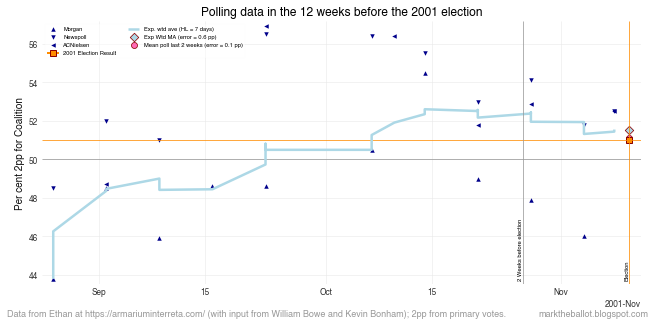

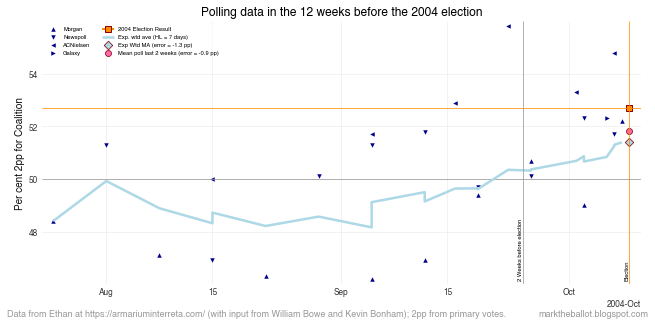

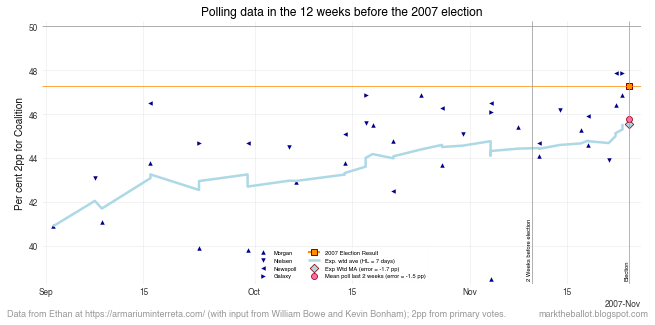

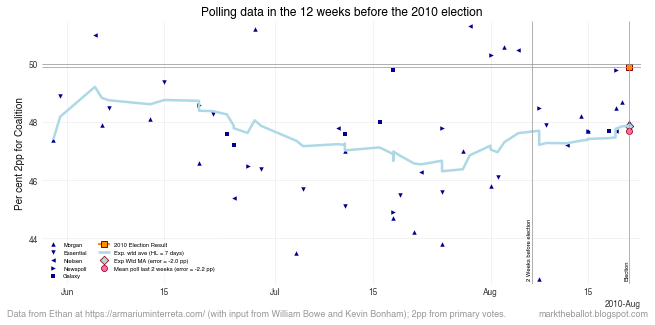

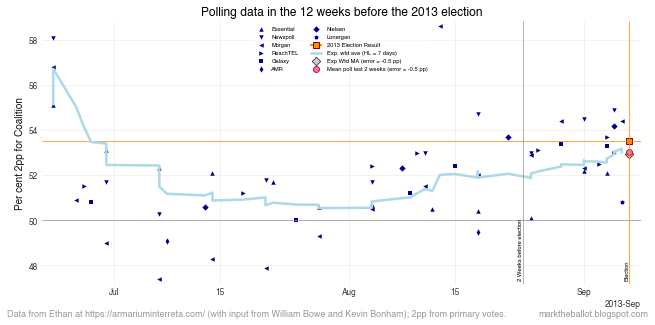

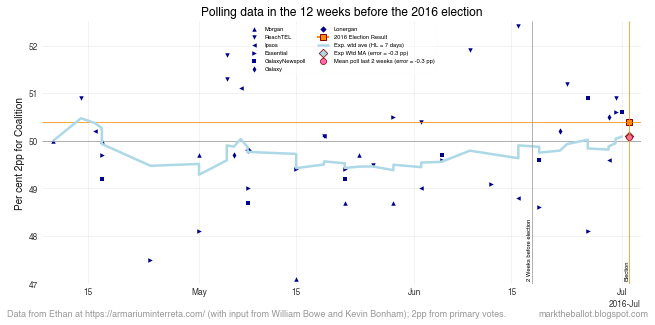

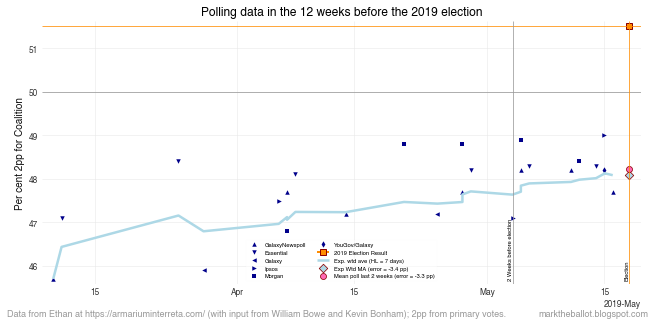

In [15]:
# --- constants
INDIV_FOCUS = 12 # weeks
HALF_LIFE = 7 # days
EWM_MARKER = 'D'
EWM_COLOR = 'lightblue'
FINAL_WEEKS = 2 # weeks - immediate prior to election

START_ANALYSIS = pd.Timestamp('1972-01-01')
# Note: no polls in final two weeks of 1977 election

MEAN_COLOR = 'hotpink'
MEAN_MARKER = 'o'

MARKERS = '^v<>sdDph'

# --- calculate and plot
ewm_errors = {}
final_errors = {}
for election in elections.Date:
    
    # ignore early polls
    if election < START_ANALYSIS:
        continue

    # get election date and outcome
    election_2pp = elections.at[election.year, 'Coalition2pp']
    final_weeks = election - pd.Timedelta(days=FINAL_WEEKS * 7)

    # get polling data
    focus_days = INDIV_FOCUS * 7 # days
    
    # get polling data
    start = election - pd.Timedelta(days=focus_days)
    selected = historical[(historical.StartDate >= start)
                          & (historical.EndDate <= election)].copy()

    # plot
    _, ax1 = common.initiate_plot()
    for i, pollster in enumerate(selected.Pollster.unique()):
        # poll data
        p_data = selected[selected.Pollster == pollster]
        p_data.plot(kind='scatter', x='EndDate', y=COALITION_TPP, ax=ax1, 
                          c=COLOR_COALITION, label=pollster, marker=MARKERS[i])
    
    ax1.plot([election], [election_2pp],
             c=ELECTION_COLOR, markeredgecolor='darkred', marker=ELECTION_MARKER,
             label=f'{election.year} Election Result')
    
    # Mark in reference line (50%) and election 2pp
    ax1.axhline(y=50, color='#999999', linestyle='-', linewidth=0.75)
    ax1.axhline(y=election_2pp, color=ELECTION_COLOR, linestyle='-', linewidth=0.75,)
    ax1.axvline(x=election, color=ELECTION_COLOR, linestyle='-', linewidth=0.75,)
    ax1.text(election, selected[COALITION_TPP].min(), 'Election', 
             rotation=90, ha='right', size='xx-small')
   
    # calculate chart the exponentially weighted moving average
    ewm = selected[COALITION_TPP].ewm(halflife=HALF_LIFE).mean()
    ewm.index = selected['EndDate']
    ewm_final = ewm.iloc[-1]
    ewm_error = ewm_final - election_2pp
    ewm_errors[election.year] = ewm_error
    ewm.plot(color=EWM_COLOR, ax=ax1, linewidth=2.5, 
             label=f'Exp. wtd ave (HL = {HALF_LIFE} days)')
    ax1.scatter([election], [ewm_final], linewidths=0.75, 
                c=EWM_COLOR, edgecolors='darkred', marker=EWM_MARKER, 
                label=f'Exp Wtd MA (error = {ewm_error:0.1f} pp)')
        
    # mark final weeks before election
    ax1.axvline(x=final_weeks, color='#999999', linestyle='-', linewidth=0.75,)
    ax1.text(final_weeks, selected[COALITION_TPP].min(), f'{FINAL_WEEKS} Weeks before election', 
             rotation=90, ha='right', size='xx-small')
    
    # average of polls for the final weeks prior to an election
    final_weeks_ave = selected.loc[selected.EndDate >= final_weeks, COALITION_TPP].mean()
    if not np.isnan(final_weeks_ave):
        final_weeks_error = final_weeks_ave - election_2pp
        final_errors[election.year] = final_weeks_error
        ax1.scatter([election], [final_weeks_ave], linewidths=0.75, 
                     c=MEAN_COLOR, edgecolors='darkred', marker=MEAN_MARKER, 
                     label='Mean poll last 2 weeks (error = '
                           f'{final_weeks_error:0.1f} pp)')
    
    # finalise the plot
    ax1.legend(loc='best', ncol=2)
    common.plot_finalise(ax1, xlabel=None, ylabel='Per cent 2pp for Coalition', 
                         lfooter=data_statement,
                         title=f'Polling data in the {INDIV_FOCUS} weeks '
                               f'before the {election.year} election',
                         concise_dates=True, straighten_tl=True)



## Simple Bayesian analysis of 2pp polling errors since 1983 (inc.)

Lets assume that polling errors are distributed by Student's t-distribution.

Then find the Student's t-distribution that best defines the distribution of polls compared with elections

### Get the data we want to look at

In [16]:
# convert above error data to a Series
# only keep error data from 1983; 
# as earlier polling is sparse and
# often just one pollster in the field.

KEEP_FROM = 1983
def retain(x: pd.Series) -> pd.Series: 
    return x[x.index >= KEEP_FROM]
s_ewm_errors = pd.Series(ewm_errors).pipe(retain)
s_final_errors = pd.Series(final_errors).pipe(retain)
print(len(s_final_errors))
pd.DataFrame(s_final_errors)#.to_html()

14


,0
1983,-1.300000
1984,-3.400000
1987,-2.316667
1990,-1.466667
1993,1.618182
1996,-1.941667
1998,-0.087500
2001,0.100000
2004,-0.877778
2007,-1.500000


### Quick look at the distribution of errors

In [17]:
# Quick report on mean polling error across elections
# +ve is pro-Coalition; -ve is pro-Labor
# Initial Observation: 
# It appears that polls have been historically
# biased to Labor on average
print('Mean EWM polling error across elections: '
      f'{s_ewm_errors.mean():0.4f}')
print(f'Mean final {FINAL_WEEKS}-week polling error across '
      f'elections: {s_final_errors.mean():0.4f}')

Mean EWM polling error across elections: -1.3073
Mean final 2-week polling error across elections: -1.2441


In [18]:
# kernel density estimate
kde = sm.nonparametric.KDEUnivariate(s_final_errors)
kde.fit()
density = pd.Series(kde.density, index=kde.support)

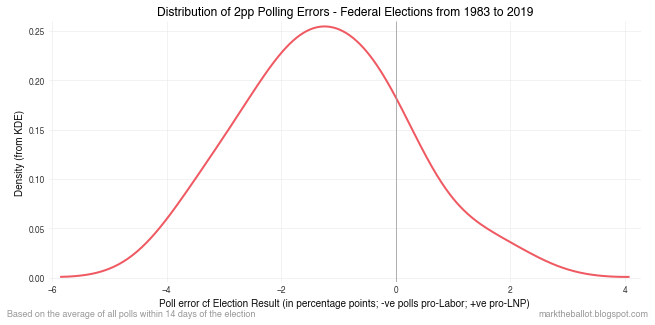

In [19]:
# plot our KDE
_, ax = common.initiate_plot()
density.plot(ax=ax)
ax.axvline(x=0, color='#999999', lw=0.75)
common.plot_finalise(ax, 
                     xlabel='Poll error cf Election Result (in percentage points; -ve polls pro-Labor; +ve pro-LNP)', 
                     ylabel='Density (from KDE)',
                     lfooter='Based on the average of all polls within 14 days of the election',
                     title='Distribution of 2pp Polling Errors - Federal Elections from 1983 to 2019')

### Build and run a Bayesian model using Student's t-distribution

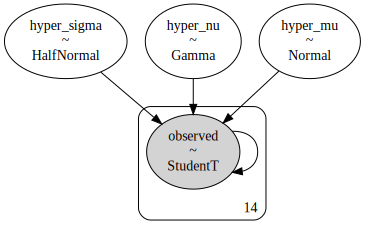

In [20]:
# construct our Bayesian model
model = pm.Model()
with model:
    hyper_mu = pm.Normal('hyper_mu', mu=0, sigma=10) # expect mode of -1 to -2 (from KDE above)
    hyper_sigma = pm.HalfNormal('hyper_sigma', sigma=10) # expect in range 1 to 2 (from KDE above)
    hyper_nu = pm.Gamma('hyper_nu', alpha=2, beta=0.1) # hard to day what I expect here
    
    observed = pm.StudentT("observed", nu=hyper_nu,
                           mu=hyper_mu, sigma=hyper_sigma,
                           observed=s_final_errors)
    
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [hyper_mu, hyper_sigma, hyper_nu]


Sampling 16 chains for 5_000 tune and 10_000 draw iterations (80_000 + 160_000 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.7051, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


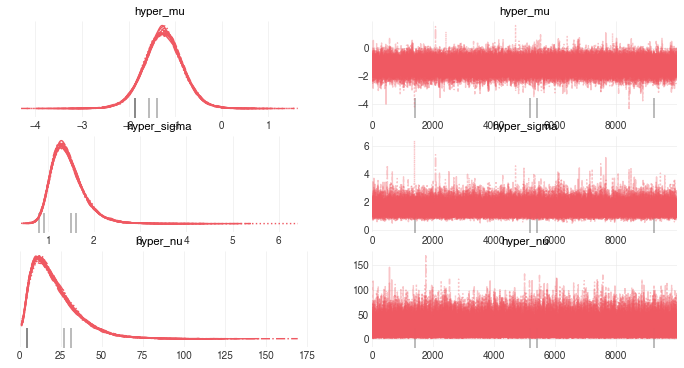

In [21]:
# sample our Bayesian model - occasionally we see a handfull of divergences.
# Usually, there are no divergences; so I am not worrying at this stage. 

with model:
    trace = pm.sample(draws=10_000, tune=5_000, chains=16, cores=16)
    summary = az.summary(trace) 
    az.plot_trace(trace)      

In [22]:
# r_hat (Gelman-Rubin convergence diagnostic) of 1 looks good
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hyper_mu,-1.257,0.416,-2.029,-0.461,0.001,0.001,134021.0,98153.0,1.0
hyper_sigma,1.439,0.355,0.863,2.112,0.001,0.001,125037.0,95371.0,1.0
hyper_nu,21.369,14.162,2.041,47.261,0.040,0.029,121439.0,94741.0,1.0


### Extract hyper_nu

In [23]:
def smooth(series):
    # a simple smoother - helps find the mode accurately
    peak = 9
    peak_width = 5 # should be odd
    smoother = list(range(1,peak+1)) + [peak] * peak_width + list(range(peak-1,0,-1))
    smoother = pd.Series(smoother)
    smoother = smoother / smoother.sum()
    smoothed = (
        series
        .rolling(window=len(smoother),
                 min_periods=len(smoother),
                 center=True)
        .apply(func=lambda x: (x * smoother.values).sum())
    )
    return smoothed.where(smoothed.notna(), other=series)

# The mean for hyper_nu may not be the best measure of its central tendency,
# let's use a ***rough*** mode, given the kurtosis of this hyper-parameter. 
BINS = 2_500
nu = np.histogram(trace
                  .posterior
                  .stack(draws=("chain", "draw"))['hyper_nu'],
                  bins = BINS)
nu_binned_raw = pd.Series(nu[0], nu[1][:-1])

N = 10 # How many times to smooth
new_binned_smoothed = nu_binned_raw
for _ in range(N):
    new_binned_smoothed = smooth(new_binned_smoothed)
    
hyper_nu_ = new_binned_smoothed.idxmax()
print(f'Unadjusted maximum: {hyper_nu}')

# adjustment for bin middle
bin_width_adjust = (new_binned_smoothed.index[1] - new_binned_smoothed.index[0]) / 2.0
hyper_nu_ += bin_width_adjust
hyper_nu_ # adjusted for our bin width

Unadjusted maximum: hyper_nu


11.39334372363172

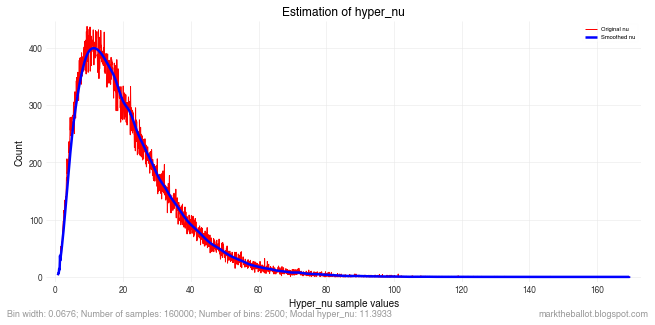

In [24]:
# Let's look at our hyper_nu samples as binned ...
_, ax = common.initiate_plot()
nu_binned_raw.plot(lw=1, c='red', label='Original nu', ax=ax)
new_binned_smoothed.plot(lw=2.5, c='blue', ax=ax, label='Smoothed nu')
ax.legend(loc='best')
common.plot_finalise(ax, xlabel='Hyper_nu sample values', ylabel='Count',
                         lfooter=f'Bin width: {bin_width_adjust * 2:0.4f}; '
                                 f'Number of samples: {nu_binned_raw.sum()}; '
                                 f'Number of bins: {len(new_binned_smoothed)}; '
                                 f'Modal hyper_nu: {hyper_nu_:0.4f}', 
                         title='Estimation of hyper_nu')

### Let's look at our proposed Student-t distribution

Compared with the KDE from our 14 data points

In [25]:
USE_MEAN_NU = False

# Key parameters for the Student's t-distribution
hyper_mu = summary.at['hyper_mu', 'mean']
hyper_sigma = summary.at['hyper_sigma', 'mean']
hyper_nu = summary.at['hyper_nu', 'mean'] if USE_MEAN_NU else hyper_nu_
[hyper_mu, hyper_sigma, hyper_nu]

[-1.257, 1.439, 11.39334372363172]

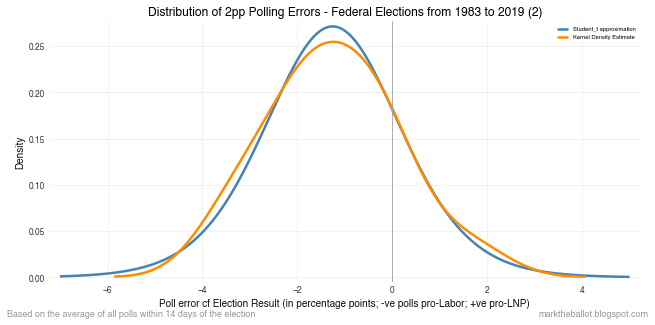

In [26]:
# and plot ...
span = np.linspace(-7, 5, 1000)
pdf = ss.t.pdf(span, df=hyper_nu, loc=hyper_mu, scale=hyper_sigma)
student_t = pd.Series(pdf, index=span)
_, ax = common.initiate_plot()
student_t.plot(c='steelblue', lw=2.5, label='Student_t approximation', ax=ax)
density.plot(c='darkorange', lw=2.5, label='Kernel Density Estimate', ax=ax)
ax.legend(loc='best')
ax.axvline(x=0, c='#999999', lw=0.75)

common.plot_finalise(ax, 
                     xlabel='Poll error cf Election Result (in percentage points;'
                            ' -ve polls pro-Labor; +ve pro-LNP)', 
                     ylabel='Density',
                     lfooter='Based on the average of all polls within '
                             '14 days of the election',
                     title='Distribution of 2pp Polling Errors - '
                           'Federal Elections from 1983 to 2019 (2)')

## Bayesian estimation of other party polling errors since 1983

### Get and adjust primary polling data

In [27]:
historical.columns

Index(['StartDate', 'EndDate', 'ElectionYear', 'FieldDays', 'DaysToElection',
       'DaysFromLastElection', 'Incumbent', 'Pollster', 'SamplingMethod',
       'SampleSize', 'ALP', 'LNC', 'Liberals', 'Nationals', 'DLP', 'Democrats',
       'Greens', 'PHON', 'Others', 'Undecided', 'Undecided2pp', 'Published2pp',
       'RespAlloc2pp', 'Raw2pp', 'Est2pp', '2pp', 'RoundedEst2pp',
       'PrimMargin', 'Result2pp', 'DevALP', 'DevLNC', 'DevLib', 'DevNat',
       'DevDLP', 'DevDem', 'DevGrn', 'DevPHON', 'DevOth', 'DevPub2pp',
       'DevEst2pp', 'Dev2pp', 'DevPastInc2pp', 'DevInc2pp', 'DevIncPrim',
       'DevOppPrim', 'AbsDevALP', 'AbsDevLNC', 'AbsDevLib', 'AbsDevNat',
       'AbsDevDLP', 'AbsDevDem', 'AbsDevGrn', 'AbsDevPHON', 'AbsDevOth',
       'AbsDevPub2pp', 'AbsDevEst2pp', 'AbsDev2pp'],
      dtype='object')

In [28]:
primary_columns = ['ALP', 'LNC', 'DLP', 'Democrats', 
                   'Greens', 'PHON', 'Others', 'Undecided']
                  # primary Undexideds deliberately left out

# Check data types - every column should be a float    
historical[primary_columns].dtypes

ALP          float64
LNC          float64
DLP          float64
Democrats    float64
Greens       float64
PHON         float64
Others       float64
Undecided    float64
dtype: object

In [29]:
# data item count
len(historical)

3252

In [30]:
#check row adds with undecideds - this looks a little messy
tally_with_u = historical[primary_columns].sum(axis=1)
tally_with_u.value_counts()

100.0    2884
101.0     145
99.0      116
98.0       12
100.1      11
107.0      11
99.9        8
99.5        7
108.0       6
107.5       4
102.0       4
100.1       4
100.0       3
108.5       3
100.5       3
106.0       3
105.0       2
108.9       2
99.9        2
100.0       2
106.5       2
97.0        2
102.5       1
105.5       1
97.5        1
0.0         1
96.0        1
88.0        1
99.8        1
100.2       1
100.2       1
110.0       1
98.6        1
104.0       1
103.5       1
98.5        1
101.5       1
99.8        1
dtype: int64

In [31]:
#check row adds without undecideds - this looks a little messy
tally_without_u = historical[primary_columns[:-1]].sum(axis=1)
tally_without_u.value_counts()

100.0    2882
101.0     136
99.0      112
92.0       12
93.0       11
100.1       9
91.0        9
98.0        8
99.5        7
94.0        7
100.1       7
99.9        7
100.0       6
90.0        5
100.5       5
102.0       4
100.0       4
99.9        3
99.8        2
100.2       1
95.5        1
97.5        1
88.0        1
96.0        1
0.0         1
98.5        1
100.2       1
98.6        1
99.9        1
103.5       1
110.0       1
105.0       1
101.5       1
97.0        1
104.0       1
dtype: int64

Let's assume the 'Undecided' column was sometimes included in the row total and sometimes it was not. This is messy.

In [32]:
# identify the rows that tally to roughly 100% (either with or without the undecideds)
KEEP_LOW, KEEP_HIGH = 98.5, 101.5
keep_mask = (
    ((tally_with_u >= KEEP_LOW) & (tally_with_u <= KEEP_HIGH))
    | ((tally_without_u >= KEEP_LOW) & (tally_without_u <= KEEP_HIGH))
)
keep_mask.sum() 

3225

In [33]:
# Make the index the end_date, and drop the rows that have addition issues 
primary_polls = historical[primary_columns[:-1]].copy().fillna(0) # ignore undecides
primary_polls['EndDate'] = historical['EndDate']
primary_polls = primary_polls[keep_mask]
primary_polls = primary_polls.set_index('EndDate')
primary_polls.sample(5)

,ALP,LNC,DLP,Democrats,Greens,PHON,Others
EndDate,,,,,,,
1997-09-11,36.0,41.5,0.0,7.5,2.0,8.5,4.5
2017-03-25,34.0,33.0,0.0,0.0,16.0,2.0,15.0
1986-07-19,44.0,47.0,0.0,7.0,0.0,0.0,2.0
2014-06-26,38.7,39.6,0.0,0.0,10.3,0.0,11.5
1983-04-02,56.0,36.0,0.0,6.0,0.0,0.0,2.0


In [34]:
# Get primary polling data and normalise to sum to 100
primary_tally = primary_polls.sum(axis=1)
primary_polls = primary_polls.div(primary_tally, axis=0) * 100
assert(all(primary_polls.sum(axis=1) < 100.01) & all(primary_polls.sum(axis=1) > 99.99))
primary_polls.sample(5).sort_index()

,ALP,LNC,DLP,Democrats,Greens,PHON,Others
EndDate,,,,,,,
1974-09-30,41.0,50.0,3.0,0.0,0.0,0.0,6.0
1990-07-28,38.5,47.5,0.0,11.0,0.0,0.0,3.0
2012-08-26,32.0,49.0,0.0,0.0,10.0,0.0,9.0
2015-05-16,35.0,43.0,0.0,0.0,13.0,0.0,9.0
2016-05-01,32.5,40.0,0.0,0.0,13.5,0.0,14.0


### Summary plot of other primary votes

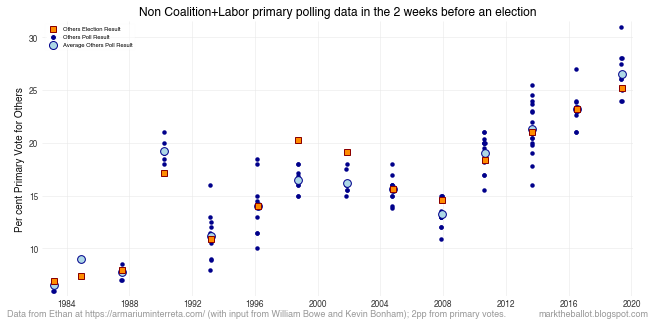

In [71]:
# Get the average for all polls N weeks before the election
N = 2
N_DAYS = N * 7 # days per week
GRAPH_START = 1983

p_others = ['DLP', 'Democrats', 'Greens', 'PHON', 'Others']
primary_polls_other = pd.DataFrame(primary_polls[p_others].sum(axis=1), columns=['Others'])
primary_polls_other['EndDate'] = primary_polls_other.index

e_others = ['DLP', 'DEM', 'GRN', 'ON', 'Others']
primary_elections_other = table[e_others].sum(axis=1)

means = {}

fig, ax = common.initiate_plot()
for election_day in elections.Date:

    e_year = election_day.year
    
    # ignore early polls
    if e_year < GRAPH_START:
        continue
        
    # get election data and plot
    election_primary_other = primary_elections_other[e_year]
    ax.plot([election_day], [election_primary_other],
            c=ELECTION_COLOR, markeredgecolor='darkred', marker=ELECTION_MARKER)
    
    # get others polling data and plot
    start = election_day - pd.Timedelta(days=N_DAYS)
    selected = primary_polls_other[(primary_polls_other.index <= election_day)
                                   & (primary_polls_other.index >= start)].copy()
    selected.plot(kind='scatter', x='EndDate', y='Others', ax=ax, 
                  c=COLOR_COALITION, marker=POLL_MARKER)
    
    means[election_day] = selected['Others'].mean()

means = pd.DataFrame(pd.Series(means), columns=['Others'])
means['EndDate'] = means.index
ax.scatter(means['EndDate'], means['Others'], s=60,
                  c='lightblue', marker='o',  edgecolor='darkblue', lw=1)

means.index = means.index.year

# legend
legend_body = [Line2D([0], [0], marker=ELECTION_MARKER, color='w', label='Others Election Result',
                          markerfacecolor=ELECTION_COLOR ,markeredgecolor='darkred', ),
              Line2D([0], [0], marker=POLL_MARKER, color='w', label='Others Poll Result',
                          markerfacecolor=COLOR_COALITION),
              Line2D([0], [0], marker='o', color='w', label='Average Others Poll Result',
                          markerfacecolor='lightblue',markeredgecolor='darkblue', ms=8)]
ax.legend(handles=legend_body, loc='best')

common.plot_finalise(ax, xlabel=None, ylabel='Per cent Primary Vote for Others', 
                     lfooter= data_statement,
                     title=f'Non Coalition+Labor primary polling data in the {N} '
                           'weeks before an election',
                     concise_dates=True, straighten_tl=True)

### Bayesian estimate

<AxesSubplot:ylabel='Density'>

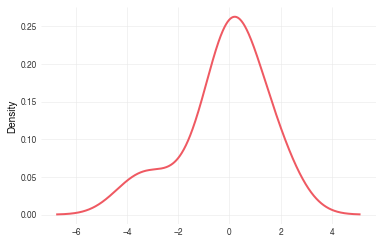

In [77]:
errors = means['Others'] - primary_elections_other[primary_elections_other.index >= GRAPH_START]
errors.plot.kde()

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w